In [76]:
pip install imageio==2.4.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Initialising the libraries

In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
import cv2
import tensorflow.keras
import random
import seaborn as sns
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [78]:
seed=25
np.random.seed(seed)
random.seed(seed)
tensorflow.random.set_seed(seed)

In [5]:
%%capture
#download the dataset
!wget --no-check-certificate https://www.crcv.ucf.edu/data/UCF50.rar
#Extracting the dataset
!unrar x UCF50.rar

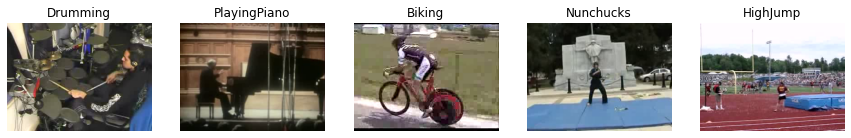

In [79]:
plt.figure(figsize=(15,15))
class_names= os.listdir('UCF50') # store the names of all classes
 
#The dataset contains 50 classes. Among them 5 classes have been randomly chosen for visualisation.
random_range= random.sample(range(len(class_names)),5)
c=0
for index in random_range:

  selected_class_name= class_names[index]   # one class_name is slected using index from the defined list of random_range 
  video_files_names=os.listdir(f'UCF50/{selected_class_name}')  # select all the video files from a specific selected class
  selected_video_file_name=random.choice(video_files_names)  # select a singe video file under the specified selected class for visualisation
  selected_video=cv2.VideoCapture(f'UCF50/{selected_class_name}/{selected_video_file_name}') 
  _, frame= selected_video.read() # read the first frame of the video file
  selected_video.release()
  plt.subplot(1,5,c+1)
  rgb_img=cv2.cvtColor(frame,cv2.COLOR_BGR2RGB) # convert the bgr frame format into rgb format
  plt.imshow(rgb_img)
  plt.title(f'{selected_class_name}')
  plt.axis('off')
  c=c+1

In [80]:
#Pre-processing the data
size=71

DATASET_dir='UCF50'

sequence_length=15  # number of sequences taken from one video which will be fed into the model

Classification_classes= ['Biking','JumpRope','Nunchucks'] # selected 3 classes manually for classification

Extracting the frames from the video files

In [81]:
def frames_extractor(path):
  frame_list= [] # store the video frames
  video= cv2.VideoCapture(path) #read the video file
  frames_count=int(video.get(cv2.CAP_PROP_FRAME_COUNT)) # count of the total frames in a single video
  skip_frames_window= max(int(frames_count/sequence_length),1) # store the skip interval after which frames added in the frame_list
  for frame_index in range(sequence_length):
    video.set(cv2.CAP_PROP_POS_FRAMES, frame_index * skip_frames_window)  # set the current position of the video
    success,frame=video.read() # read the current frame of the video
    if not success:
      break
    frame_resized=cv2.resize(frame,(size,size)) # frame is resized into (128,128) shape
    normalised_frame= frame_resized/255.0 # normalised the frame by dividing 255.0 and the pixels value now between 0 and 1
    frame_list.append(normalised_frame) 
  video.release()
  return frame_list    

Creating the dataset for the classification

In [82]:
def dataset():
  frame_features=[]  ## store the features
  labels= []   ## store the labels of the classes which are being classified
  video_paths=[] 

  for class_index,class_name in enumerate(Classification_classes):
    files_list= os.listdir(os.path.join(DATASET_dir,class_name)) # store the list of the video_files under a specific class

    for file_name in files_list:
      file_path= os.path.join(DATASET_dir,class_name,file_name)
      video_frames= frames_extractor(file_path) # extracting the video_frames array by using frames_extractor function

      if len(video_frames)==sequence_length: # store only those video_frmes whose length are same as sequence length
        frame_features.append(video_frames)
        labels.append(class_index)
        video_paths.append(file_path)

  frame_arrays=np.asarray(frame_features)
  labels=np.array(labels)                    ## converting the list into array

  return frame_arrays, labels, video_paths

In [83]:
frame_arrays,labels,video_paths=dataset()

In [84]:
labels_encoded=to_categorical(labels) # converting the labels into one_hot_encoded labels

In [85]:
x_train,x_test,y_train,y_test= train_test_split(frame_arrays, labels_encoded, test_size=0.3, shuffle= True) # split the dataset into 70% training and 30% testing data

Extracting features using VGG16 based transfer learing CNN model

In [86]:
x_train.shape

(310, 15, 71, 71, 3)

In [87]:
# for extracting the features using CNN model, shape of the x_train and x_test is converted from 5-dimensional array to four dimensional array where 1st dimension represents the total number of frames present in the x_train and x_test
train_dataset_array=np.reshape(x_train,(x_train.shape[0]*x_train.shape[1],x_train.shape[2],x_train.shape[3],x_train.shape[4]))
test_dataset_array=np.reshape(x_test,(x_test.shape[0]*x_test.shape[1],x_test.shape[2],x_test.shape[3],x_test.shape[4]))

In [88]:
train_dataset_array.shape

(4650, 71, 71, 3)

In [89]:
from tensorflow.keras.applications.vgg16 import VGG16
def CNN_extractor(dataset_array):

  VGG16_model=VGG16(weights='imagenet',include_top=False,input_shape=(size,size,3))

  for layer in VGG16_model.layers:
      layer.trainable=False

  VGG16_features=VGG16_model.predict(dataset_array)
  VGG16_features=VGG16_features.reshape(VGG16_features.shape[0],-1)
  return VGG16_features

In [90]:
train_features= CNN_extractor(train_dataset_array)  # extracting train and test features using VGG16 network
test_features= CNN_extractor(test_dataset_array)

63/63 [==============================] - 96s 2s/step


In [91]:
train_features.shape

(4650, 2048)

LSTM Model for time-series sequence as video frame are in time-series sequential data

In [92]:
## Reshaping the training  and testing features into again time-series sequence and then used LSTM model for classification
train_features_LSTM=np.reshape(train_features,(x_train.shape[0],x_train.shape[1],train_features.shape[1]))
test_features_LSTM=np.reshape(test_features,(x_test.shape[0],x_test.shape[1],test_features.shape[1]))

In [93]:
train_features_LSTM.shape  # shape of the features which will be fed into the LSTM model

(310, 15, 2048)

In [94]:
##LSTM model build
model=Sequential()
model.add(LSTM(100,input_shape=(train_features_LSTM.shape[1], train_features_LSTM.shape[2]),kernel_regularizer=tensorflow.keras.regularizers.l2(0.0001),activation='relu',return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32,kernel_regularizer=tensorflow.keras.regularizers.l2(0.0001),activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16))
model.add(Dropout(0.2))
model.add(Dense(len(Classification_classes),activation='softmax'))

# regularizer, dropout layer is used to overcome the overfitting

In [95]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 15, 100)           859600    
                                                                 
 dropout_6 (Dropout)         (None, 15, 100)           0         
                                                                 
 lstm_5 (LSTM)               (None, 32)                17024     
                                                                 
 dropout_7 (Dropout)         (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 16)                528       
                                                                 
 dropout_8 (Dropout)         (None, 16)                0         
                                                                 
 dense_5 (Dense)             (None, 3)                

In [96]:
model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])
callback=tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss',patience=15)
model_history= model.fit(train_features_LSTM, y_train,epochs=100, batch_size=16, validation_split=0.15,callbacks=[callback],verbose=1)

Epoch 1/100
17/17 [==============================] - 5s 103ms/step - loss: 1.0957 - accuracy: 0.4943 - val_loss: 0.7942 - val_accuracy: 0.6596
Epoch 2/100
17/17 [==============================] - 1s 68ms/step - loss: 0.7013 - accuracy: 0.7224 - val_loss: 0.4997 - val_accuracy: 0.7660
Epoch 3/100
17/17 [==============================] - 1s 70ms/step - loss: 0.5778 - accuracy: 0.7947 - val_loss: 0.5866 - val_accuracy: 0.7872
Epoch 4/100
17/17 [==============================] - 1s 71ms/step - loss: 0.5852 - accuracy: 0.8137 - val_loss: 0.4665 - val_accuracy: 0.8085
Epoch 5/100
17/17 [==============================] - 1s 68ms/step - loss: 0.2736 - accuracy: 0.9125 - val_loss: 0.4410 - val_accuracy: 0.9149
Epoch 6/100
17/17 [==============================] - 1s 69ms/step - loss: 0.3319 - accuracy: 0.9049 - val_loss: 0.4819 - val_accuracy: 0.8936
Epoch 7/100
17/17 [==============================] - 1s 69ms/step - loss: 0.2099 - accuracy: 0.9468 - val_loss: 0.4349 - val_accuracy: 0.8511
Epoch

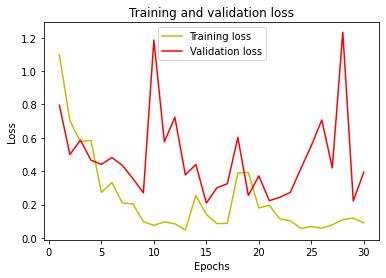

In [97]:
train_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

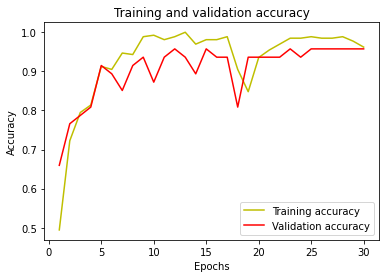

In [98]:
train_accuracy = model_history.history['accuracy']
val_accuracy = model_history.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_accuracy, 'y', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Evaluate the training model using test_dataset

In [99]:
evaluation_history= model.evaluate(test_features_LSTM,y_test)

5/5 [==============================] - 0s 38ms/step - loss: 0.6596 - accuracy: 0.9248


5/5 [==============================] - 0s 27ms/step
[[34  6  2]
 [ 0 41  0]
 [ 0  2 48]]


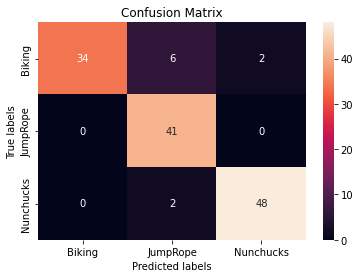

In [100]:
y_predict=model.predict(test_features_LSTM)
y_predi=[np.argmax(element) for element in y_predict]
y_true=[np.argmax(element) for element in y_test]
cm=confusion_matrix(y_true,y_predi)
ax=plt.subplot()
print(cm)
sns.heatmap(cm, annot=True)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Biking','JumpRope','Nunchucks'])
ax.yaxis.set_ticklabels(['Biking','JumpRope','Nunchucks']);

In [101]:
from sklearn.metrics import classification_report
print(classification_report(y_true,y_predi))

              precision    recall  f1-score   support

           0       1.00      0.81      0.89        42
           1       0.84      1.00      0.91        41
           2       0.96      0.96      0.96        50

    accuracy                           0.92       133
   macro avg       0.93      0.92      0.92       133
weighted avg       0.93      0.92      0.92       133



Save the model

In [106]:
model.save('/content/drive/MyDrive/Colab Notebooks/VGG16+LSTM_model.h5')

In [107]:
model.save('/content/drive/MyDrive/Colab Notebooks/')